In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import linregress

# Calibrating Frequency / Voltage

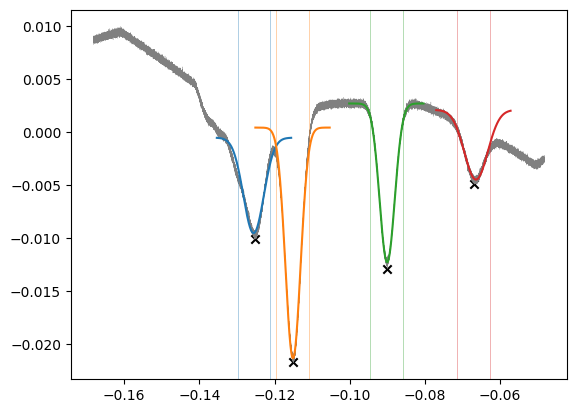

In [153]:
dataframe = read_csv("4_4_1-V2.CSV", names=["t","c1", "c2"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
t, c1, c2 = data[:, 0], data[:, 1], data[:, 2]

# Find peaks (without gaussians)
peaks = find_peaks(-c2, height=0.004, distance=10000)[0]
xpeaks = np.array([t[i] for i in peaks])
ypeaks = np.array([c2[i] for i in peaks])

# voltage at peaks (not good cause of voltage jitter, should fit a straight line first)
peakVoltages = np.array([c1[i] for i in peaks])

# fit gaussian to each peak
peak_width = 5000 # given in number of neighbouring datapoints
peak_skew_factor = 1.8 # > 1 shifts boundaries further right
gaussian_fit_boundaries = [(int(i - peak_width), int(i + peak_skew_factor * peak_width / 2)) for i in peaks]

# fit function
def gaussian(vL, A, v0, vD, DC_offset):
	return - A * np.exp(-4 * np.log(2) * pow((vL - v0) / vD, 2)) + DC_offset

# fitting and plotting
for i, (LB, UB) in enumerate(gaussian_fit_boundaries):
    initialguess = 0.003, xpeaks[i], 0.01 / 2, 0.1
    (A, v0, vD, DC_offset), _ = curve_fit(gaussian, t[LB:UB], c2[LB:UB], initialguess)

    plot_boundary_extension = 6000
    x_gaussian_fit = np.linspace(t[LB-plot_boundary_extension], t[UB+plot_boundary_extension], num=1000)
    y_gaussian_fit = gaussian(x_gaussian_fit, A, v0, vD, DC_offset)

    plt.plot(x_gaussian_fit, y_gaussian_fit, '-', c='C'+str(i), zorder=100)

#plot original signal
plt.scatter(xpeaks, ypeaks, marker='x', c='black')
plt.plot(t[::1], c2[::1], linewidth=0.2, c='gray')

# plot gaussian_fit_boundaries
for peak_number, boundaries in enumerate(gaussian_fit_boundaries):
    for bound in boundaries:
        plt.axvline(x=t[bound], color='C'+ str(peak_number), alpha=0.5, linewidth=0.5)

## Same thing with Intensity in terms of laser control voltage

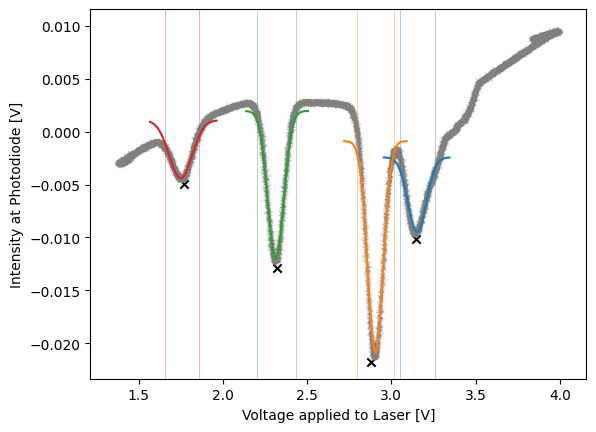

In [155]:
dataframe = read_csv("4_4_1-V2.CSV", names=["t","c1", "c2"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
t, c1, c2 = data[:, 0], data[:, 1], data[:, 2]

# Find peaks (without gaussians)
peaks = find_peaks(-c2, height=0.004, distance=10000)[0]
xpeaks = np.array([c1[i] for i in peaks])
ypeaks = np.array([c2[i] for i in peaks])

# voltage at peaks (not good cause of voltage jitter, should fit a straight line first)
peakVoltages = np.array([c1[i] for i in peaks])

# fit gaussian to each peak
peak_width = 5000 # given in number of neighbouring datapoints
peak_skew_factor = 1.8 # > 1 shifts boundaries further right
gaussian_fit_boundaries = [(int(i - peak_width), int(i + peak_skew_factor * peak_width / 2)) for i in peaks]

# fit function
def gaussian(vL, A, v0, vD, DC_offset):
	return - A * np.exp(-4 * np.log(2) * pow((vL - v0) / vD, 2)) + DC_offset

# fitting and plotting
for i, (LB, UB) in enumerate(gaussian_fit_boundaries):
    initialguess = 0.003, xpeaks[i], 0.01 / 2, 0.01
    (A, v0, vD, DC_offset), _ = curve_fit(gaussian, c1[LB:UB], c2[LB:UB], initialguess)

    plot_boundary_extension = 4000
    x_gaussian_fit = np.linspace(c1[LB-plot_boundary_extension], c1[UB+plot_boundary_extension], num=1000)
    y_gaussian_fit = gaussian(x_gaussian_fit, A, v0, vD, DC_offset)

    plt.plot(x_gaussian_fit, y_gaussian_fit, '-', c='C'+str(i), zorder=100)

#plot original signal
plt.scatter(xpeaks, ypeaks, marker='x', c='black')
plt.plot(c1[::1], c2[::1], linewidth=0.05, c='gray')
plt.ylabel("Intensity at Photodiode [V]")
plt.xlabel("Voltage applied to Laser [V]")
# plot gaussian_fit_boundaries
for peak_number, boundaries in enumerate(gaussian_fit_boundaries):
    for bound in boundaries:
        plt.axvline(x=c1[bound], color='C'+ str(peak_number), alpha=0.5, linewidth=0.5)

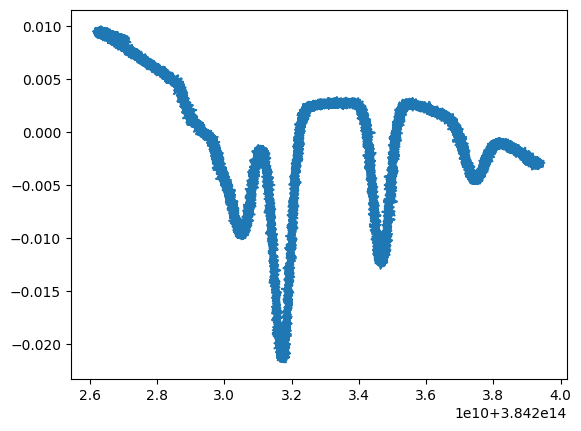

In [43]:
f0 = 384.2304844685e12
f1 = f0 + 1.296117462789e9
f2 = f1 + 3.035732439e9 
f3 = f2 + 2.500832709015e9
peakFrequencies = np.array([f0,f1,f2,f3])

df_dv, intercept, _, _, _ = linregress(peakVoltages, peakFrequencies)

freq = c1 * df_dv + intercept
plt.plot(freq[::1], c2[::1])
